In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

C:\ProgramData\Miniconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:37: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:38: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
C:\ProgramData\Miniconda3\lib\site-packages\keras\utils\image_utils.py:39: DeprecationWar

In [2]:
problem = "MountainCarContinuous-v0"
env = gym.make(problem)

# This is needed to get the input size for the NN
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# This is needed to clip the actions within the legal boundaries
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  2
Size of Action Space ->  1
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


C:\ProgramData\Miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
# This is a noise used in the paper that introduced DDPG https://arxiv.org/pdf/1509.02971v6.pdf
# From what I understand, we can also use Gaussian or other noise without much difference,
# I left the noise as is
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [5]:
def policy(state, noise_object, noise_mult=1, use_noise=True):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [27]:
class Agent:
    def __init__(self, buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # Its important to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(layer1=400, layer2=300)
        self.critic_model = get_critic(layer1=400, layer2=300)

        self.target_actor = get_actor(layer1=400, layer2=300)
        self.target_critic = get_critic(layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object, use_noise=True, noise_mult=1):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [7]:
# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [15]:
def run(total_trials=3, total_episodes=100, use_curve=False, curve_scale=1, use_momentum=False, 
                buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002, render=False,
                actor_lr=0.001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=False, directory='Weights/',
               actor_name='car_actor', critic_name='car_critic'):
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(buffer_capacity=buffer_capacity, batch_size=batch_size, std_dev=std_dev, 
                critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = agent.policy(tf_prev_state, agent.ou_noise, noise_mult=noise_mult)
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                if use_curve:
                    # https://medium.com/reinforcement-learning-w-policy-gradients/mountaincarcontinous-cheating-8446b09647ba
                    # true_state = np.abs(np.cos(np.pi/3.) + state[0])
                    # reward += -(1. - true_state)
                    
                    # I am a bit unsure how the curve is calculated (it just says sinusoidal on the webpage)
                    # I base my attempt at the bottom being -0.5 and top right being 0.5
                    # so the below code is my attempt at this type of reward
                    reward += (np.sin(state[0] * np.pi) + 1)/curve_scale
                    # it adds 0 at the bottom and 2 at the top of the curve
                    # adds curve scale as the reward could be too high
                    
                if use_momentum:
                    # having 0 speed and being in 0,5 (which i guess is the bottom) should incur max penalty
                    # having max speed and beging in 0,5 should not give any penalty
                    # the rest of the penalties should be smooth around the bottom with regards to the speed
                    reward -= max(0, np.cos(state[1]*np.pi*10))*max(0, np.cos((state[0]+0.5)*np.pi*2))
                    #this version gives penalty for 0.05 or lower speeds in ca. range -0.7 to -0.3

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-40:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(ep_reward_list[trial][-40:])
            print("Episode * {} * Avg Reward is ==> {} * true_avg_reward: {} * time used: {}"
                  .format(ep, avg_reward, true_avg_reward, (time.time() - before)))
            avg_reward_list[trial].append(avg_reward)

        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (40)")
    plt.legend()
    plt.show()

Episode * 0 * Avg Reward is ==> -583.701860972774 * true_avg_reward: -42.06855567513751 * time used: 9.994060516357422
Episode * 1 * Avg Reward is ==> -489.34099486379455 * true_avg_reward: -59.782075626172016 * time used: 9.59800124168396
Episode * 2 * Avg Reward is ==> -449.8302997701858 * true_avg_reward: -72.64888086601546 * time used: 9.454610109329224
Episode * 3 * Avg Reward is ==> -424.58562968562063 * true_avg_reward: -75.13746098576573 * time used: 9.55469822883606
Episode * 4 * Avg Reward is ==> -347.3227789659035 * true_avg_reward: -51.87619736539519 * time used: 8.889802694320679
Episode * 5 * Avg Reward is ==> -279.5553628124181 * true_avg_reward: -29.036256174603682 * time used: 2.0098319053649902
Episode * 6 * Avg Reward is ==> -229.11277752117303 * true_avg_reward: -11.932935743937966 * time used: 0.9606940746307373
Episode * 7 * Avg Reward is ==> -191.84051297796225 * true_avg_reward: 0.8990512985940313 * time used: 1.0149576663970947
Episode * 8 * Avg Reward is ==> -

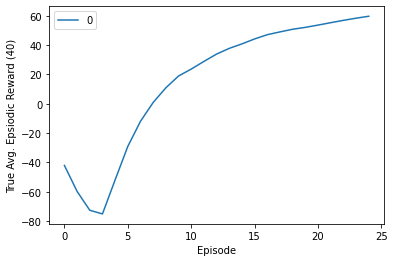

In [16]:
run(total_trials=1, total_episodes=25, use_momentum=True, save_weights=True)

In [ ]:
run(total_trials=1, total_episodes=100, use_momentum=True)

In [28]:
def test(total_episodes=100, actor_weights='Weights/car_actor-trial0.h5', render=False):
    rewards = []
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(buffer_capacity=0, batch_size=0, std_dev=0, 
                critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(tf_prev_state, 0, use_noise=False)
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

3.0013697147369385s
3.016434669494629s
3.2139885425567627s
2.9639909267425537s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.061471939086914s


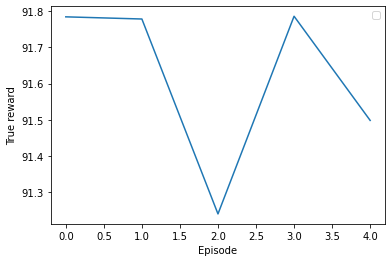

In [29]:
test(total_episodes=5, render=True)